In [ ]:
import nltk
nltk.download('punkt_tab') # This resource is not needed and causes an error

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.iloc[:, :2]  # Keeping only the first two columns
df.columns = ['label', 'text']

# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])  # spam = 1, ham = 0
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['label'].value_counts()

,count
label,
0,4825
1,747


In [ ]:
# Re-run preprocessing with Tokenizer and pad_sequences
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt', force=True)
nltk.download('wordnet')
nltk.download('stopwords')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = text.lower() # Convert to lowercase
    tokens = nltk.word_tokenize(text) # Tokenize - removing language='english'
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [stemmer.stem(word) for word in tokens] # Stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatization
    return ' '.join(tokens)

df['text'] = df['text'].apply(preprocess_text)

# Tokenization and Padding
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# Determine max sequence length after preprocessing
max_len = max([len(x) for x in sequences])

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Now padded_sequences contains the word embedding representation of your text data.
# You will use this for training your model with LSTMs.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Train-test split using padded_sequences
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

In [ ]:
# Model with Bidirectional LSTM layers for padded sequences
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128), # Input layer for padded sequences
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Reduced units in the second LSTM
    tf.keras.layers.Dense(32, activation='relu'), # Reduced units in the dense layer
    tf.keras.layers.Dropout(0.4), # Increased dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Label smoothing to prevent overconfident predictions
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2)

# Compile with Adam optimizer
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Increased patience

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop]) # Increased epochs

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Calculate precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.8930 - loss: 0.4696 - val_accuracy: 0.9803 - val_loss: 0.3503
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.9913 - loss: 0.3501 - val_accuracy: 0.9830 - val_loss: 0.3452
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9960 - loss: 0.3427 - val_accuracy: 0.9830 - val_loss: 0.3483
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9987 - loss: 0.3398 - val_accuracy: 0.9821 - val_loss: 0.3477
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.9994 - loss: 0.3384 - val_accuracy: 0.9839 - val_loss: 0.3483
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9839 - loss: 0.3425
Test Accuracy: 0.9830
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step

Confusion Matrix:
[[959   6]
 [ 13 137]]

Precision: 0.9580
Recall: 0.9133
F1-score: 0.9352


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


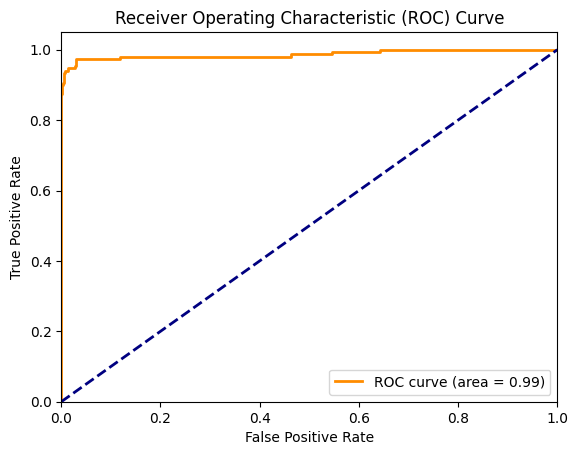

AUC Score: 0.9871


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_pred_proba = model.predict(X_test)[:, 0]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       965
        Spam       0.96      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
def predict_sample(texts):
    preprocessed_texts = [preprocess_text(text) for text in texts]
    sequences = tokenizer.texts_to_sequences(preprocessed_texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    predictions = model.predict(padded_sequences)
    return ['Spam' if p > 0.5 else 'Ham' for p in predictions]

sample_texts = [
    "Congratulations! You have won a free iPhone. Click here to claim now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "You are selected for a $1000 gift card. Reply now to claim!",
    "Reminder: Your doctor's appointment is scheduled for 3 PM tomorrow."
]

print(predict_sample(sample_texts))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
['Spam', 'Ham', 'Spam', 'Ham']


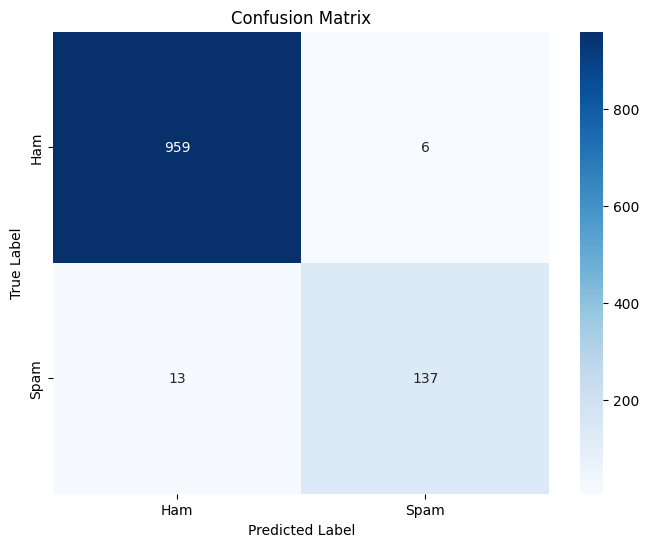


Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       965
        Spam       0.96      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'cm' is your confusion matrix calculated previously
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Assuming y_test and y_pred are available from previous steps
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])
print("\nClassification Report:")
print(report)